# Exemplo MNIST
[Script baseado nesse exemplo](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/sagemaker-experiments/mnist-handwritten-digits-classification-experiment)

In [30]:
import sys

In [31]:
!{sys.executable} -m pip install sagemaker-experiments

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


### Install PyTorch

In [3]:
!{sys.executable} -m pip install torch
!{sys.executable} -m pip install torchvision

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


### Setup

In [4]:
import time

import boto3
import numpy as np
import pandas as pd
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
from torchvision import datasets, transforms

import sagemaker
from sagemaker import get_execution_role
from sagemaker.session import Session
from sagemaker.analytics import ExperimentAnalytics

from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker

In [5]:
sess = boto3.Session()
sm = sess.client('sagemaker')
role = get_execution_role()

### Bucket S3 para dados

In [6]:
# create a s3 bucket to hold data, note that your account might already created a bucket with the same name
account_id = sess.client('sts').get_caller_identity()["Account"]
bucket = 'sagemaker-experiments-{}-{}'.format(sess.region_name, account_id)
prefix = 'mnist'

try:
    if sess.region_name == "us-east-1":
        sess.client('s3').create_bucket(Bucket=bucket)
    else:
        sess.client('s3').create_bucket(Bucket=bucket, 
                                        CreateBucketConfiguration={'LocationConstraint': sess.region_name})
except Exception as e:
    print(e)

### Dataset

In [7]:
# download the dataset
# this will not only download data to ./mnist folder, but also load and transform (normalize) them
train_set = datasets.MNIST('mnist', train=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))]), 
    download=True)
                           
test_set = datasets.MNIST('mnist', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))]),
    download=False)

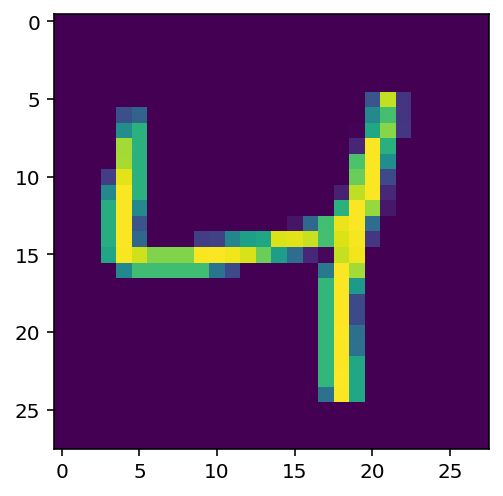

In [8]:
plt.imshow(train_set.data[2].numpy())

Upload para S3

In [9]:
inputs = sagemaker.Session().upload_data(path='mnist', bucket=bucket, key_prefix=prefix)
print('input spec: {}'.format(inputs))

input spec: s3://sagemaker-experiments-us-east-1-725879053979/mnist


### Treinando modelo pela primeira vez
Observar que script é salvo no S3 apenas após fazermos `estimator.fit(...)`.

Se quisermos customizar onde queremos salvar script no S3, basta setar no estimator o 
[`code_location`](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html#sagemaker.estimator.Framework)

Nas linhas de log dentro desse notebook podemos ver onde no S3 salvamos script:

``` 
(...)
Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "training": "/opt/ml/input/data/training"
    
    ( . . . )
    
    "module_dir": "s3://sagemaker-us-east-1-725879053979/cnn-training-job-FIXED/source/sourcedir.tar.gz",
    "module_name": "mnist",
    
    ( . . . )
    
    "user_entry_point": "mnist.py"
    
    ( . . . )
}
(...)
```

In [10]:
from sagemaker.pytorch import PyTorch, PyTorchModel

In [11]:
# teste com Regex
estimator = PyTorch(
        entry_point='./mnist.py',
        role=role,
        sagemaker_session=sagemaker.Session(sagemaker_client=sm),
        framework_version='1.1.0',
        train_instance_count=1,
        train_instance_type='ml.c4.xlarge',
        hyperparameters={
            'epochs': 1,
            'backend': 'gloo',
            'hidden_channels': 10,
            'dropout': 0.2,
            'kernel_size': 5,
            'optimizer': 'sgd'
        },
        metric_definitions=[
            {'Name':'train:loss', 'Regex':'\[Train Loss (.*?)\]'},
            {'Name':'test:loss', 'Regex':'\[Test Average loss (.*?)\]'},
            {'Name':'test:accuracy', 'Regex':'\[Test Accuracy (.*?)\]'}
        ],
        enable_sagemaker_metrics=True
    )    

In [12]:
cnn_training_job_name = "framework-script-local-{}".format(int(time.time()))

In [13]:
estimator.fit(
    inputs={'training': inputs}, 
    job_name=cnn_training_job_name,
    wait=True,
)

INFO:sagemaker:Creating training-job with name: framework-script-local-1596156081


2020-07-31 00:41:22 Starting - Starting the training job...
2020-07-31 00:41:24 Starting - Launching requested ML instances......
2020-07-31 00:42:41 Starting - Preparing the instances for training......
2020-07-31 00:43:40 Downloading - Downloading input data...
2020-07-31 00:44:16 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-07-31 00:44:17,308 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-07-31 00:44:17,311 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-07-31 00:44:17,322 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-07-31 00:44:17,323 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-07-31 00:44:17,617 sagemaker-containers INFO     Module mnist does not provide a setup.py. 
Generating setu

### Treinar modelo pela segunda vez, mas agora usando script já no S3

Um detalhe interessante aqui é que os scripts podem ficar em um git (ao invés de ficarem aqui localmente ou no S3) - olhar [parâmetro git_config](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html#sagemaker.estimator.Framework) ([PyTorch estimator](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/sagemaker.pytorch.html#pytorch-estimator) herda essa classe)

In [14]:
previous_training_analytics = estimator.training_job_analytics

In [15]:
# Regex capturou métricas
previous_training_analytics.dataframe()

,timestamp,metric_name,value
0,0.0,train:loss,0.458213
1,60.0,train:loss,0.264757
2,0.0,test:loss,0.167900
3,60.0,test:loss,0.106000
4,0.0,test:accuracy,95.000000
5,60.0,test:accuracy,97.000000


In [16]:
bucket = sagemaker.Session().default_bucket()
s3_script = f's3://{bucket}/{cnn_training_job_name}/source/sourcedir.tar.gz'
print('s3_script', s3_script)

s3_script s3://sagemaker-us-east-1-725879053979/framework-script-local-1596156081/source/sourcedir.tar.gz


In [32]:
estimator = PyTorch(
        entry_point='./mnist.py',
        source_dir=s3_script,
        role=role,
        sagemaker_session=sagemaker.Session(sagemaker_client=sm),
        framework_version='1.1.0',
        train_instance_count=1,
        train_instance_type='ml.c4.xlarge',
        hyperparameters={
            'epochs': 2,
            'backend': 'gloo',
            'hidden_channels': 10,
            'dropout': 0.2,
            'kernel_size': 5,
            'optimizer': 'sgd'
        },
        metric_definitions=[
            {'Name':'train:loss', 'Regex':'\[Train Loss (.*?)\]'},
            {'Name':'test:loss', 'Regex':'\[Test Average loss (.*?)\]'},
            {'Name':'test:accuracy', 'Regex':'\[Test Accuracy (.*?)\]'}
        ],
        enable_sagemaker_metrics=True
    )    

In [33]:
cnn_training_job_name = "framework-script-s3-{}".format(int(time.time()))

In [34]:
estimator.fit(
    inputs={'training': inputs}, 
    job_name=cnn_training_job_name,
    wait=True,
)

INFO:sagemaker:Creating training-job with name: framework-script-s3-1596159559


2020-07-31 01:39:23 Starting - Starting the training job...
2020-07-31 01:39:25 Starting - Launching requested ML instances.........
2020-07-31 01:41:08 Starting - Preparing the instances for training......
2020-07-31 01:42:08 Downloading - Downloading input data...
2020-07-31 01:42:36 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-07-31 01:42:57,597 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-07-31 01:42:57,599 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-07-31 01:42:57,611 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-07-31 01:42:57,859 sagemaker_pytorch_container.training INFO     Invoking user training script.

2020-07-31 01:42:56 Training - Training image download completed. Training in progress.2020-07-31 01:43:59,130 sagemaker-containers I

### Deploy com script de inferencia

É possível utilizar um script apenas para inferência. Container de inferência carrega modelo pré-treinado do S3 e executa lógica provida nas inferências.

De forma similar ao treinamento, os scripts de inferência podem ficar em um git (ao invés de ficarem aqui localmente ou no S3) - olhar [parâmetro git_config](https://sagemaker.readthedocs.io/en/stable/api/inference/model.html#sagemaker.model.FrameworkModel) ([PyTorchModel](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/sagemaker.pytorch.html#pytorch-model) herda essa classe)

In [20]:
artifact_location = estimator.model_data
print('Local do artefato do último treinamento do estimator:\n', artifact_location)

Local do artefato do último treinamento do estimator:
 s3://sagemaker-us-east-1-725879053979/framework-script-s3-1596156335/output/model.tar.gz


In [21]:
# Usando código específico para inferência
pytorch_model = PyTorchModel(model_data=artifact_location, 
                             role=role,
                             entry_point='inference.py', 
                             framework_version='1.1.0')

In [29]:
pytorch_model.uploaded_code

UserCode(s3_prefix='s3://sagemaker-us-east-1-725879053979/sagemaker-pytorch-2020-07-31-00-51-18-859/sourcedir.tar.gz', script_name='inference.py')

In [22]:
predictor = pytorch_model.deploy(
    instance_type='ml.t2.medium', 
    initial_instance_count=1)

INFO:sagemaker:Creating model with name: sagemaker-pytorch-2020-07-31-00-51-19-087
INFO:sagemaker:Creating endpoint with name sagemaker-pytorch-2020-07-31-00-51-19-087


-----------------!

### Realizando inferências

Para desenvolvimento poderiamos usar apenas o `predictor.predict(my_payload)`, mas vamos usar o client do SageMaker Runtime (o que seria algo produtivo).


In [25]:
import torch
loader = iter(torch.utils.data.DataLoader(train_set))

i, l = next(loader)

plt.imshow(i.squeeze().numpy())

In [26]:
image = np.array(i.numpy(), dtype=np.float32)

In [27]:
# Usando SageMaker Runtime para inferências
runtime = boto3.client('sagemaker-runtime')
print('endpoint name:', predictor.endpoint)

endpoint name: sagemaker-pytorch-2020-07-31-00-51-19-087


In [28]:
from io import BytesIO

#Serialise numpy ndarray as bytes
buffer = BytesIO()
# Assuming testX is a data frame
np.save(buffer, image)

response = runtime.invoke_endpoint(
    EndpointName=predictor.endpoint,
    Body=buffer.getvalue(),
    ContentType='application/x-npy',
    Accept='application/x-npy')

prediction = response['Body'].read()
stream = BytesIO(prediction)
prediction = np.load(stream, allow_pickle=True)

print(prediction.argmax(axis=1)[0])

5


### Cleanup

In [30]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: sagemaker-pytorch-2020-07-26-01-55-34-120
INFO:sagemaker:Deleting endpoint with name: sagemaker-pytorch-2020-07-26-01-55-34-120
